Crea un efecto de realidad aumentada dinámico. Los objetos virtuales deben cambiar de forma, posición o tamaño siguiendo alguna lógica, y el usuario puede observar la escena cambiante desde cualquier punto de vista moviendo la cámara alrededor del marcador.


Funciones necesarias.

In [4]:
import numpy as np
import cv2   as cv
from ipywidgets          import interactive
import matplotlib.pyplot as plt
import numpy.linalg      as la
%matplotlib inline

def fig(w,h):
    plt.figure(figsize=(w,h))
    
def readrgb(file):
    return cv.cvtColor( cv.imread(file), cv.COLOR_BGR2RGB)

def rgb2gray(x):
    return cv.cvtColor(x,cv.COLOR_RGB2GRAY)





def imshowg(x):
    plt.imshow(x, "gray")

# para imprimir arrays con el número de decimales deseados
import contextlib

@contextlib.contextmanager
def printoptions(*args, **kwargs):
    original = np.get_printoptions()
    np.set_printoptions(*args, **kwargs)
    yield
    np.set_printoptions(**original)

def sharr(a, prec=3):
    with printoptions(precision=prec, suppress=True):
        print(a)

# muestra un polígono cuyos nodos son las filas de un array 2D
def shcont(c, color='blue', nodes=True):
    x = c[:,0]
    y = c[:,1]
    x = np.append(x,x[0])
    y = np.append(y,y[0])
    plt.plot(x,y,color)
    if nodes: plt.plot(x,y,'.',color=color, markerSize=11)

# crea un vector (array 1D), conveniente para hacer operaciones matemáticas
def vec(*argn):
    return np.array(argn)

# convierte un conjunto de puntos ordinarios (almacenados como filas de la matriz de entrada)
# en coordenas homogéneas (añadimos una columna de 1)
def homog(x):
    ax = np.array(x)
    uc = np.ones(ax.shape[:-1]+(1,))
    return np.append(ax,uc,axis=-1)

# convierte en coordenadas tradicionales
def inhomog(x):
    ax = np.array(x)
    return ax[..., :-1] / ax[...,[-1]]

# aplica una transformación homogénea h a un conjunto
# de puntos ordinarios, almacenados como filas
def htrans(h,x):
    return inhomog(homog(x) @ h.T)

pi = np.pi
degree = pi/180


# para dibujar en 3D
from mpl_toolkits.mplot3d import Axes3D

# crea una matriz columna a partir de elementos o de un vector 1D
def col(*args):
    a = args[0]
    n = len(args)
    if n==1 and type(a) == np.ndarray and len(a.shape) == 1:
        return a.reshape(len(a),1)
    return np.array(args).reshape(n,1)

# crea una matriz fila
def row(*args):
    return col(*args).T

# juntar columnas
def jc(*args):
    return np.hstack(args)

# juntar filas
def jr(*args):
    return np.vstack(args)

# dibujar una polilínea en 3D
def plot3(ax,c,color):
    x,y,z = c.T
    ax.plot(x,y,z,color)
    
    
# espacio nulo de una matriz, que sirve para obtener el centro
# de la cámara
def null1(M):
    u,s,vt = la.svd(M)
    return vt[-1,:]


# Descomposición RQ (que no suele estar en los paquetes numéricos)
# pero es fácil expresar en términos de la QR.
# Descompone una matriz como producto de triangular x rotación
# (que es justo la estructura de una matriz de cámara)
# M = K [R |t ]
# el trozo KR te lo da la descomposición rq 
def rq(M):
    Q,R = la.qr(np.flipud(np.fliplr(M)).T)
    R   = np.fliplr(np.flipud(R.T))
    Q   = np.fliplr(np.flipud(Q.T))
    return R,Q


# Descomposición de la matriz de cámara como K,R,C
def sepcam(M):

    K,R = rq (M[:,:3])

    # para corregir los signos de f dentro de K
    s = np.diag(np.sign(np.diag(K)))

    K = K @ s     # pongo signos positivos en K
    K = K/K[2,2]  # y hago que el elemento 3,3 sea 1

    R = s @ R     # cambio los signos igual a R para compensar
    R = R*np.sign(la.det(R)) # y hago que tenga det = 1 (bien orientado)

    # el centro de proyección es el espacio nulo de la matriz,
    # el único punto que la cámara "no puede ver", porque al proyectarlo
    # produce (0,0,0), que es un vector homogéneo "ilegal"
    C = inhomog(null1(M))

    return K,R,C
    
# Permite dibujar la posicion de la camara en un modelo 3d
# esquema en 3d de una cámara
def cameraOutline(M):

    K,R,C = sepcam(M)
    
    # formamos una transformación 3D para mover la cámara en el origen a la posición de M
    rt = jr(jc(R, -R @ col(C)),
            row(0,0,0,1))
    
    sc = 0.3;
    x = 1;
    y = x;
    z = 0.99;
    
    ps =[x,    0,    z,
         (-x), 0,    z,
         0,    0,    z,
         0,    1.3*y,z,
         0,    (-y), z,
         x,    (-y), z,
         x,    y,    z,
         (-x), y,    z,
         (-x), (-y), z,
         x,    (-y), z,
         x,    y,    z,
         0,    y,    z,
         0,    0,    z,
         0,    0,    0,
         1,    1,    z,
         0,    0,    0,
         (-1), 1,    z,
         0,    0,    0,
         (-1), (-1), z,
         0,    0,    0,
         (1), (-1),  z,
         0,    0,    0,
         0,    0,    (2*x)]
    
    ps = np.array(ps).reshape(-1,3)
    return htrans(la.inv(rt), sc * ps)

# Introducción
Para crear un efecto RA tenemos que aplicar
una serie de transformada.

$$\mathsf M = \mathsf {K\, P\, R\, T}$$

- Mover la cámara al punto del espacio deseado con una traslación 𝖳
(que establece el centro de proyección).
- Orientarla para que apunte en la dirección deseada con una rotación 𝖱
(que establece el plano de imagen).
- Proyectar los puntos 3D con la matriz de proyección 𝖯
- "Digitalizar" la imagen con la matriz de calibración 𝖪


En la practica se usa una transformada mas compacta

$$ \mathsf M = \mathsf K\, [R\, \mid t ] $$

donde 𝑅 es la rotación (3×3) y 𝐶 es el centro de proyección (3×1), ambos en coordenadas cartesianas, y 𝑡=−𝑅𝐶. La notación [⋅|⋅] indica una matriz por bloques. (La proyección 𝖯 no aparece explícitamente en la expresión pero sí sus efectos).

La parte $[R\mid t]$ se llama **pose** de la cámara. Codifica la posición y orientación de la cámara en el espacio. Tiene 6 grados de libertad: 3 del centro de proyección y 3 de la rotación (p. ej. 3 ángulos). Son los parámetros "extrínsecos" o externos.

La matriz $\mathsf K$ contiene los parámetros "intrínsecos" o internos, que no dependen de la posición en el espacio ni del sistema de referencia elegido para el espacio 3D. Puede tener hasta 5 grados de libertad (aunque no todos son igual de importantes).

En conjunto son 11 grados de libertad, que cuadran con los 12 elementos de la matriz homogéna $\mathsf M$ (tiene un factor de escala arbitrario).


Lo que buscamos en esta practica es que usando varios puntos ya conocidos generemos una matriz M y usando esa matriz
añadiremos elemento de realidad aumentada a la escena.

## ¿Como obtenemos la matriz M ?
Es posible extraer los componentes 𝖪, 𝑅 y 𝐶
de cualquier matriz de cámara 𝑀, lo que permite recuperar su posición en el espacio.
Pero para mayor precisión es muy conveniente precalibrar la cámara y estimar solo la "pose" (𝑅 y 𝐶). Para ello se utiliza la función solvePnP de OpenCV ("Perspective from 𝑛 Points) que resuelve la estimación de pose de forma muy eficiente. Se necesitan solo 3 puntos correspondientes para determinar los 6 parámetros pero para que haya solución única son necesarios 4 ó más.

Para recuperar la pose necesitamos la matriz de calibración 𝖪.

In [5]:
# mide el error de una transformación (p.ej. una cámara)
# rms = root mean squared error
# "reprojection error"
def rmsreproj(view, model, transf):
    err = view - htrans(transf,model)
    return np.sqrt(np.mean(err.flatten()**2))

def pose(K, image, model):
    ok,rvec,tvec = cv.solvePnP(model, image, K, (0,0,0,0))
    if not ok:
        return 1e6, None
    R,_ = cv.Rodrigues(rvec)
    M = K @ jc(R,tvec)
    rms = rmsreproj(image,model,M)
    return rms, M

Para obtener la matriz de calibracion usamos `cv.findChessboardCorners`

In [6]:
K = np.array([[769.62724632,   0.0         ,488.46157162],
 [  0.0         ,772.62443378, 271.09322874],
 [  0.0           ,0.0           ,1.0        ]])
K

array([[769.62724632,   0.        , 488.46157162],
       [  0.        , 772.62443378, 271.09322874],
       [  0.        ,   0.        ,   1.        ]])

Para eso leemos la imagen:

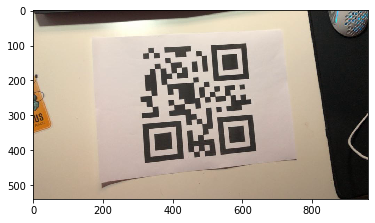

In [7]:
img = readrgb('../img/RA/qrbueno.png')
img_copia = img.copy()
img_puntos_proyectados = img.copy()
plt.imshow(img);

array([[300, 111],
       [321, 436],
       [639, 402],
       [609,  95]])

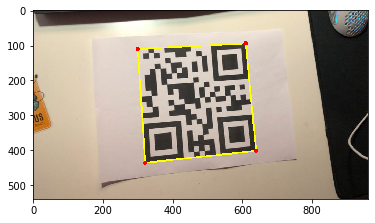

In [8]:
from pyzbar.pyzbar import decode



for barcode in decode(img):
    data = barcode.data
    rect = barcode.rect
    points = barcode.polygon
    # Convertirmos el namedTupple a Numpy array para que opencv lo entienda.
    #print(points)
    pointsOpencv = []
    for point in points:
        pointArray = [point.x,point.y]
        pointsOpencv.append(pointArray)
    pts_reales = np.array(pointsOpencv, np.int32)
    pts = pts_reales.reshape((-1,1,2))
    cv.polylines(img_copia, [pts],True ,(255, 255, 0),4)
    [cv.circle(img_copia, (point.x,point.y), 6, [255,0,0],-1) for point in points]
plt.imshow(img_copia);
pts_reales

Ya tenemos el recangulo en el mundo real ahora vamos a crear una figura de referencia.

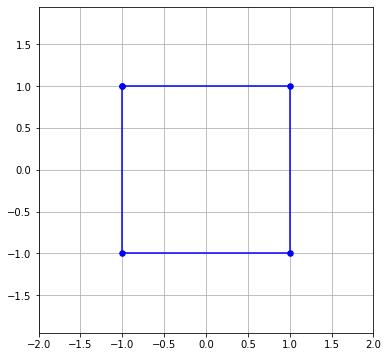

In [9]:
ref = (np.array(
   [[-1,   1  ],[1,   1  ],
    [1,-1  ],[-1, -1]]))

fig(6,6)
shcont(ref);
plt.axis('equal'); plt.axis(2*vec(-1,1,-1,1)); plt.grid()

Convertirmos la referencia en 3d

In [10]:
# añadimos una coordenada cero a todas las filas
# para convertir un polígono del plano en un polígono
# en el espacio, a altura z=0
def addzerocol(x):
    return np.hstack([x,np.zeros([len(x),1])])

ref3d = addzerocol(ref)
ref3d

array([[-1.,  1.,  0.],
       [ 1.,  1.,  0.],
       [ 1., -1.,  0.],
       [-1., -1.,  0.]])

In [11]:
error, Me = pose(K, pts_reales.astype(float), ref3d)
print(f"El error es de  {error} pixeles")

El error es de  0.6318697204472264 pixeles


El error de modelo en este caso 0.6 pixeles un dato bastante bueno.
Dibujamos la cámara estimada en el espacio junto con el marcador detectado y comprobamos visualmente que la posición relativa es correcta.

In [12]:
camline = cameraOutline(Me)

def fun(a=-30):
    fig = plt.figure(figsize=(8,7))
    ax = fig.gca(projection='3d')
    #ax.axis('equal')
    plot3(ax,ref3d,'r');
    plot3(ax,camline,'b');
    ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
    ax.view_init(elev=30., azim=a)
    

interactive(fun, a = (-180,180,10))

interactive(children=(IntSlider(value=-30, description='a', max=180, min=-180, step=10), Output()), _dom_class…

Vamos a proyectar los puntos sobre la imagen

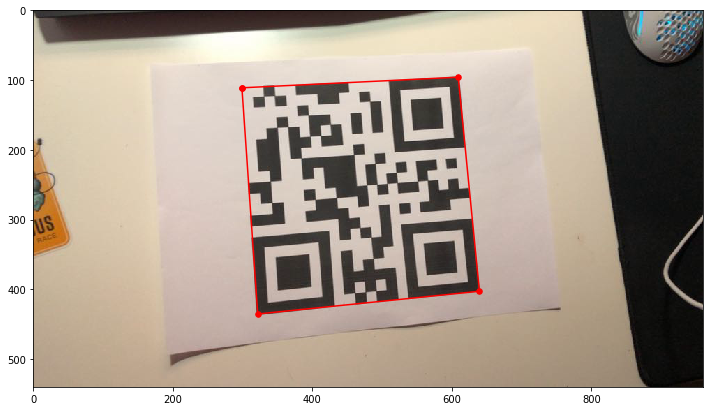

In [13]:
img_puntos_proyectados = img.copy()
fig(12,8)
plt.imshow(img); ax = plt.axis();

shcont( htrans(Me,ref3d), color='red')

plt.axis(ax);

Dibujamos un cuadrado encima

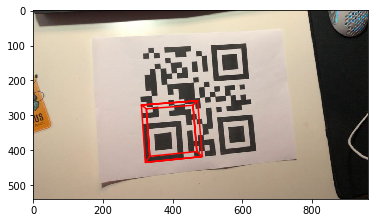

In [14]:
cube = np.array([
    [0,0,0],
    [1,0,0],
    [1,1,0],
    [0,1,0],
    [0,0,0],

    [0,0,1],
    [1,0,1],
    [1,1,1],
    [0,1,1],
    [0,0,1],

    [1,0,1],
    [1,0,0],
    [1,1,0],
    [1,1,1],
    [0,1,1],
    [0,1,0]
    ])
plt.imshow(img); ax = plt.axis();
shcont(htrans(Me,cube),nodes=False,color='red')
plt.axis(ax);



Ahora es cuando empieza la magia y digo magia porque no se como mostrar opengl en un documento jupyter

Lo que voy a hacer va a ser cargar un modelo 3 obj usando pygame y openGl.
Luego creare la `view matrix` que transforma los vertices del mundo del objeto al mundo de la cámara.
¿Como se calcula la matriz Vista ?
De muchas maneras pero como tenemos en este caso la matriz de la camara es solo su inversa.
$$V=M^1$$

Hay aqui hay un poco de jaleo porque no se si la matriz M es la matriz camara o la matriz V y luego que 
que M no es cuadrada asique no puedo hacer su inversa lo que si que puedo hacer es 

$$V = inverse( R * translate(t) );$$ Siendo R la matriz 4x4 de rotation  que me da Rodrigues   y t el vector de translacion que me da solvePnP
Yo entiendo esto:

- La matriz de la tranformadada de la camara *M* (Camera Transformation Matrix): La matriz para calcular la posicion de la camara.
- La matriz de vista ( View Matrix): la matriz que transforma vertices del espacio del objeto al mundo que ve la camara.Es decir del modelado 3d al mundo real visto por la camara.
![](../img/RA/View-Matrix.png)

La matriz que he calculado antes es la M asique voy a calcular su inversa.
Que pasa que M no es cuadrada asique no puedo calcular su inversa por lo que voy a calcular la matriz view de otra manera que he visto en un bloque de código.




In [15]:
model = ref3d
image = pts_reales.astype(float)
ok,rvecs,tvecs = cv.solvePnP(model, image, K, (0,0,0,0))
rmtx = cv.Rodrigues(rvecs)[0]
view_matrix = np.array([[rmtx[0][0],rmtx[0][1],rmtx[0][2],tvecs[0][0]],
                                     [rmtx[1][0],rmtx[1][1],rmtx[1][2],tvecs[1][0]],
                                     [rmtx[2][0],rmtx[2][1],rmtx[2][2],tvecs[2][0]],
                                     [0.0       ,0.0       ,0.0       ,1.0    ]])

In [16]:
view_matrix

array([[ 0.08621439, -0.98868649, -0.12274403, -0.10901973],
       [ 0.99377188,  0.0766117 ,  0.0809203 , -0.07986303],
       [-0.07060118, -0.12895606,  0.98913387,  4.86539937],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

Tenemos varios problemas la imagen se ve al reves y nuestra captura de QR no suele encontrar los puntos.

![](../img/RA/problemas.jpg)

Solucion usar los maravillosos arucos que son una especie de qr pero para posionar puntos en el espacio
![](../img/RA/aruco.png)
Problema de los Aruocs que los vectores de rotacion y translacion estan calculados en el centro y tenemos que mover nuestra fugura a una esquina.


De cualquier manera trabajar con openGl es bastante tedioso por lo que voy a usar solamente OpenVC

Para reconocer ArUco tengo que importar su diccionario en este caso trabajaremos con los originales.
Luego creo una lista de parametros en este caso usamos los por defecto, convertimos la imagen a escalado de gris y llamamos a `detectMarkers` que como su nombre indica detecta las esquinas y los ids de los propios ArUcos


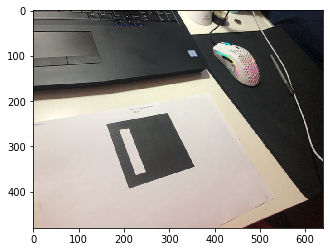

In [21]:
img = cv.imread('../img/RA/arucoid0.png')
img_aruco = img.copy()
img_rgb = cv.cvtColor( img, cv.COLOR_BGR2RGB)
plt.imshow(img_rgb);

In [23]:
import cv2.aruco as aruco
aruco_dict = aruco.Dictionary_get(aruco.DICT_ARUCO_ORIGINAL)
parameters = aruco.DetectorParameters_create()
gray = cv.cvtColor(img_aruco, cv.COLOR_BGR2GRAY)
corners, ids, rejectedImgPoints = aruco.detectMarkers(gray, aruco_dict, parameters=parameters)
print(corners)

[array([[[162., 251.],
        [296., 227.],
        [356., 344.],
        [211., 392.]]], dtype=float32)]


Luego usando `aruco.estimatePoseSingleMarkers` podemos obtener los vectores de translacion y rotacion.

In [28]:
cam_matrix = np.array([
    [517.8722750974446,0.0,240.17807128953407],
    [0.0,513.9990577718563,318.9122194573285],
    [0.0,0.0,1.0]])
dist_coefs = np.array([
    [0.24597505311362036,-1.34989679906235,-8.086536552562445e-05,
      0.0023665474816139294,2.254314221917189]
])
rvecs, tvecs, _objpoints = aruco.estimatePoseSingleMarkers(corners, 0.5, cam_matrix, dist_coefs)

In [30]:
def pose(K, rvec, tvec):
    rvec_goodShape = rvec.reshape(3, -1)
    tvec_goodShape = tvec.reshape(3, -1)
    R, _ = cv.Rodrigues(rvec_goodShape)
    M = K @ jc(R, tvec_goodShape)
    return M
# Calculamos la matriz
rvec = rvecs[0]
tvec = tvecs[0]
M = pose(cam_matrix, rvec, tvec)

In [31]:
M

array([[ 5.51437657e+02, -9.31039773e+01, -1.14565959e+02,
         4.38898853e+02],
       [-2.18026144e+01, -3.23269024e+02, -5.10805070e+02,
         5.10037636e+02],
       [ 3.16895820e-01,  3.71226080e-01, -8.72793353e-01,
         1.70360844e+00]])

In [34]:
from umucv.util import lineType
cv.drawContours(img_rgb, [htrans(M, cube).astype(int)], -1, (0, 128, 0), 3, lineType)
aruco.drawAxis(img_rgb, cam_matrix, dist_coefs, rvec, tvec, 0.1)

array([[[111, 107, 105],
        [ 72,  68,  66],
        [107, 100,  99],
        ...,
        [ 34,  33,  48],
        [ 33,  32,  47],
        [ 31,  30,  45]],

       [[181, 177, 175],
        [122, 118, 116],
        [116, 109, 108],
        ...,
        [ 30,  29,  44],
        [ 28,  27,  42],
        [ 26,  25,  40]],

       [[131, 127, 125],
        [ 92,  88,  86],
        [ 84,  77,  76],
        ...,
        [ 28,  29,  43],
        [ 26,  27,  41],
        [ 24,  25,  39]],

       ...,

       [[205, 185, 158],
        [205, 185, 158],
        [206, 186, 159],
        ...,
        [ 26,  13,   8],
        [ 28,  15,  10],
        [ 27,  14,   9]],

       [[204, 184, 157],
        [205, 185, 158],
        [206, 186, 159],
        ...,
        [ 27,  14,   9],
        [ 29,  16,  11],
        [ 27,  14,   9]],

       [[204, 184, 157],
        [205, 185, 158],
        [206, 186, 159],
        ...,
        [ 27,  14,   9],
        [ 29,  16,  11],
        [ 27,  14,   9]]

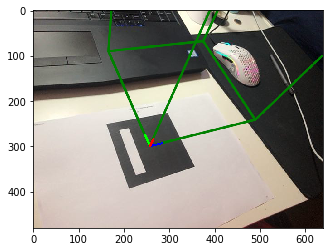

In [35]:
plt.imshow(img_rgb);

Un video mostrando el codigo
<video controls src="../img/RA/videoRA.mp4" />